In [3]:
import torch
from torch import nn, optim
from jcopdl.callback import Callback, set_config

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [4]:
from torchvision.models import mobilenet_v2

mnet = mobilenet_v2(pretrained=True)

for param in mnet.parameters():
    param.requires_grad = False

Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to C:\Users\WIN10/.cache\torch\hub\checkpoints\mobilenet_v2-b0353104.pth


In [5]:
class CustomMobilenetV2(nn.Module):
    def __init__(self, output_size):
        super().__init__()
        self.mnet = mobilenet_v2(pretrained=True)
        self.freeze()
        self.mnet.classifier = nn.Sequential(
            nn.Linear(1280, output_size),
            nn.LogSoftmax()
        )
        
    def forward(self, x):
        return self.mnet(x)

    def freeze(self):
        for param in self.mnet.parameters():
            param.requires_grad = False
            
    def unfreeze(self):        
        for param in self.mnet.parameters():
            param.requires_grad = True        

In [8]:
weights = torch.load("model/weights_best.pth", map_location="cpu")
config = torch.load("model/configs.pth", map_location="cpu")
model = CustomMobilenetV2(2)
model.load_state_dict(weights)
model = model.to(device)
model

CustomMobilenetV2(
  (mnet): MobileNetV2(
    (features): Sequential(
      (0): ConvBNReLU(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU6(inplace=True)
      )
      (1): InvertedResidual(
        (conv): Sequential(
          (0): ConvBNReLU(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU6(inplace=True)
          )
          (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (2): InvertedResidual(
        (conv): Sequential(
          (0): ConvBNReLU(
            (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=F

In [10]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from PIL import Image, ImageDraw, ImageFont
import matplotlib.pyplot as plt
import seaborn as sns
import requests
from io import BytesIO

In [11]:
bs = 50

crop_size = 256

test_transform = transforms.Compose([
    transforms.Resize(260),
    transforms.CenterCrop(crop_size),
    transforms.ToTensor()
])

test_set = datasets.ImageFolder("New Masks Dataset/Val", transform=test_transform)
testloader = DataLoader(test_set, batch_size=bs,  shuffle=True)

In [12]:
feature, target = next(iter(testloader))
feature.shape

torch.Size([6, 3, 256, 256])

In [13]:
with torch.no_grad():
    model.eval()
    output = model(feature.to(device))
    preds = output.argmax(1)
preds

C:\Users\WIN10\miniconda3\envs\jcopdl\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


tensor([0, 1, 1, 1, 0, 0], device='cuda:0')

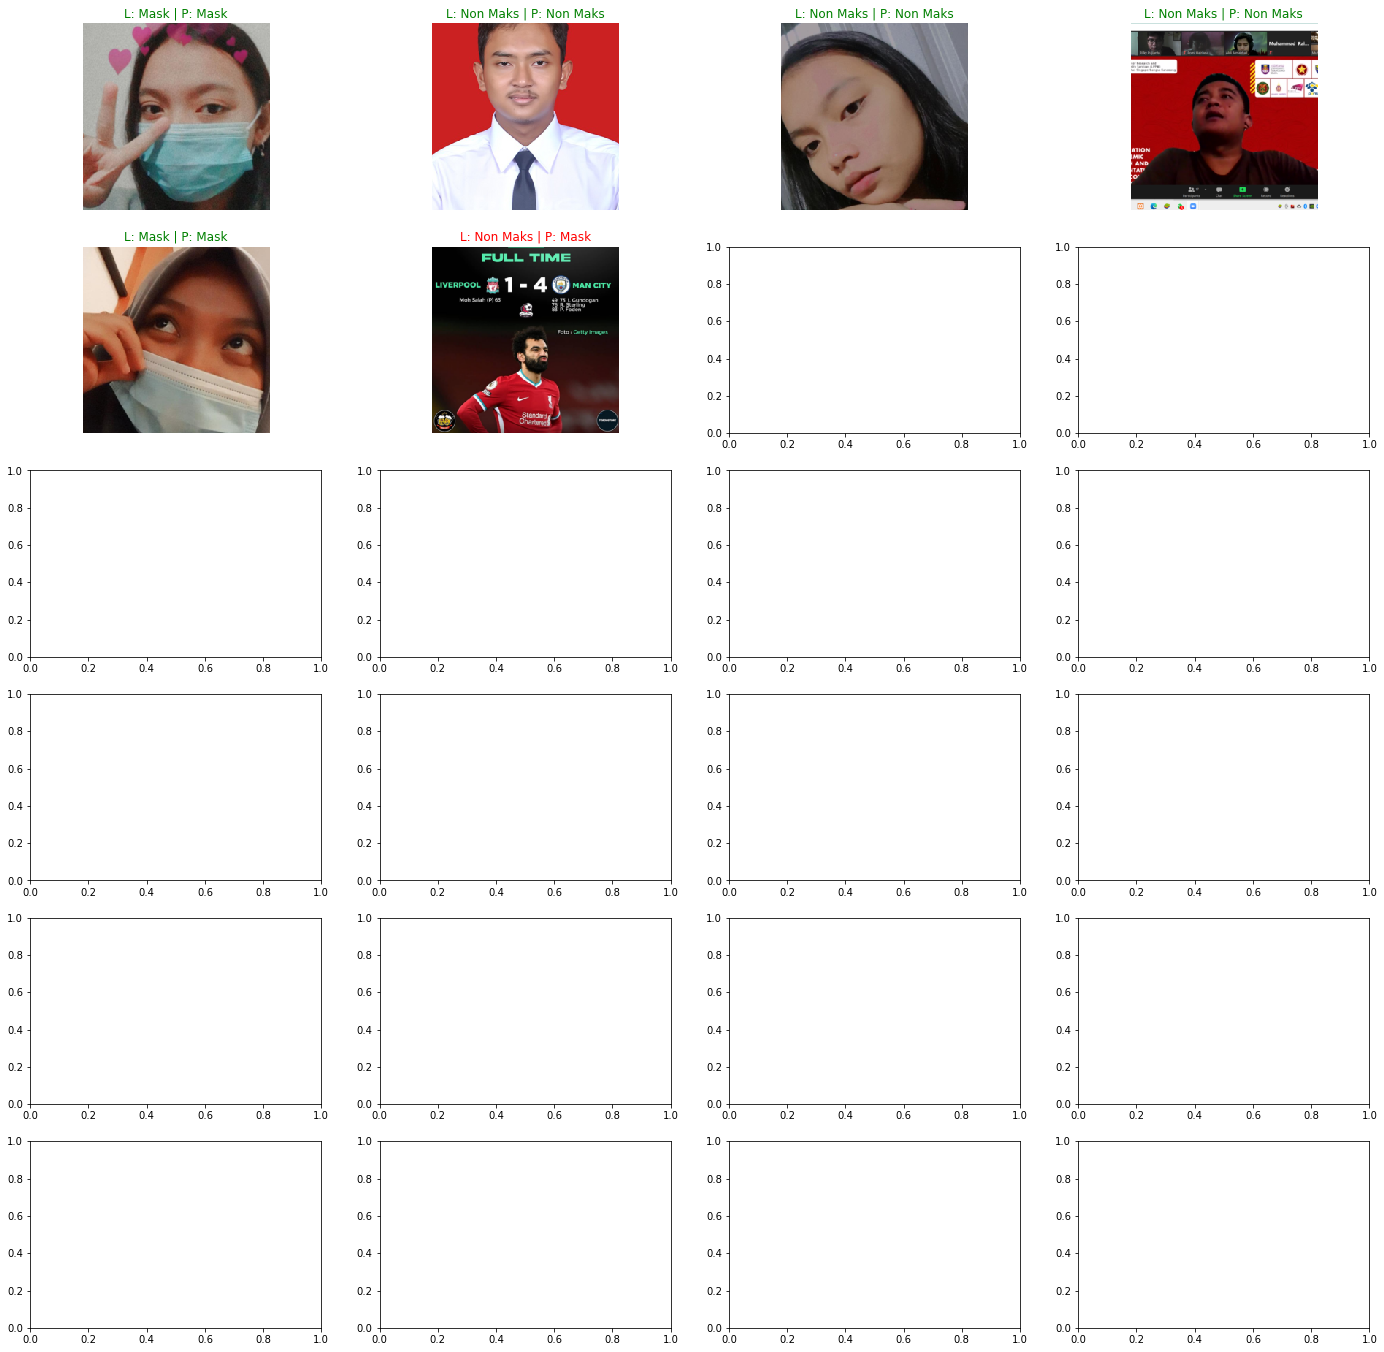

In [15]:
fig, axes = plt.subplots(6, 4, figsize=(24, 24))
for image, label, pred, ax in zip(feature.cpu(), target.cpu(), preds.cpu(), axes.flatten()):
    ax.imshow(image.permute(1, 2, 0).cpu())
    font = {"color": 'r'} if label != pred else {"color": 'g'}        
    label, pred = test_set.classes[label.item()], test_set.classes[pred.item()]
    ax.set_title(f"L: {label} | P: {pred}", fontdict=font);
    ax.axis('off');